# Deep Learning with PyTorch Lightning and Transformers

In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict, Tuple

from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
from pytorch_lightning import Trainer, callbacks, seed_everything
from pytorch_lightning.loggers import WandbLogger

import torch
import torchmetrics
from torch import nn
from torch.utils.data import WeightedRandomSampler

from transformers import AutoModel, BertTokenizerFast

In [16]:
datafile_path = "../data/04_feature/preprocessed_data.json"
with open(datafile_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)

In [17]:
df.columns

Index(['post_was_edited', 'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request', 'requester_received_pizza',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc',
       'cleaned_text'],
      dtype='object')

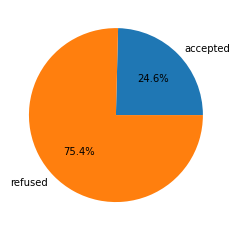

In [18]:
accepted = df[df["requester_received_pizza"] == 1].shape[0]
refused = df[df["requester_received_pizza"] == 0].shape[0]
total = accepted + refused

plt.pie([accepted, refused], labels=["accepted", "refused"], autopct="%1.1f%%")
plt.show()


The dataset is really unbalanced, but we can still train a model on it and adapt weights when calculating the loss.

<AxesSubplot:>

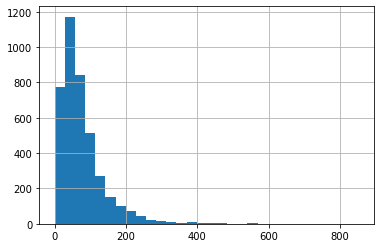

In [9]:
seq_len = [len(i.split()) for i in df["cleaned_text"]]

pd.Series(seq_len).hist(bins = 30)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df["requester_received_pizza"], test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3, stratify=y_train)

X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

print(f"Training set size: {len(X_train)}, {len(y_train)}")
print(f"Validation set size: {len(X_val)}, {len(y_val)}")
print(f"Test set size: {len(X_test)}, {len(y_test)}")

Training set size: 2424, 2424
Validation set size: 808, 808
Test set size: 808, 808


## Modeling

We will use `DistilBERT` as our base model.

Why not `BERT`?

The distillation of the original model will give us a faster model with good performances on downstream tasks like classification.

In [11]:
class RequestClassifier(pl.LightningModule):
    """
    Simple classifier class to say if the request deserve a pizza or not
    """
    def __init__(
        self, 
        max_seq_len: int = 400, 
        batch_size: int = 256, 
        learning_rate: float = 1e-3,
        n_classes: int = None,
    ) -> None:
        """
        Initialize the model with the parameters given and add new layers for our downstream task

        Parameters
        ----------
        max_seq_len: int
            Maximum length of the sequence used to pad the input, default 400
        batch_size: int
            Batch size for training, default is 256
        learning_rate: float
            Learning rate for the optimizer of the model, default 1e-3
        n_classes: int
            Number of classes in the dataset, default is None
        """
        super().__init__()
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        if n_classes is not None:
            self.n_classes = n_classes
        else:
            raise ValueError("n_classes must be specified.")

        # Training metrics
        self.loss = nn.CrossEntropyLoss(weight=torch.tensor([0.68, 2.0]))
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        self.test_accuracy = torchmetrics.Accuracy()
        # self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        # self.precision = torchmetrics.Precision(num_classes=self.n_classes, average=None)
        # self.recall = torchmetrics.Recall(num_classes=self.n_classes)
        # self.f1_score = torchmetrics.F1Score(num_classes=self.n_classes)

        self.model = AutoModel.from_pretrained("bert-base-uncased", num_labels=self.n_classes)
        self.model.eval() # Set model to evaluation mode
        for param in self.model.parameters():
            param.requires_grad = False # Freeze all the weights and prevent the existing layers from training

        self.classification_layers = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, self.n_classes),
            nn.LogSoftmax(dim=1)
        )

    
    def forward(self, encode_id: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model

        Parameters
        ----------
        encode_id: torch.Tensor
            Tensor of shape (batch_size, max_seq_len) containing the encoded ids of the input sequence
        mask: torch.Tensor
            Tensor of shape (batch_size, max_seq_len) containing the mask of the input sequence
        
        Returns
        -------
        torch.Tensor
            Tensor of shape (batch_size, 2) containing the logits of the model
        """
        output = self.model(encode_id, attention_mask=mask)
        logits = self.classification_layers(output["last_hidden_state"])
        return logits[:, -1]

    
    def prepare_data(self) -> None:
        """
        Load the data for the model and prepare it for training, validation and testing.
        """
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

        # Tokenize and encode the input sequences for training, validation and testing
        tokens_train = self.tokenizer.batch_encode_plus(
            X_train, 
            max_length=self.max_seq_len, 
            pad_to_max_length=True, 
            truncation=True, 
            return_token_type_ids=False, 
            return_tensors="pt"
        )
        tokens_val = self.tokenizer.batch_encode_plus(
            X_val, 
            max_length=self.max_seq_len, 
            pad_to_max_length=True, 
            truncation=True, 
            return_token_type_ids=False, 
            return_tensors="pt"
        )
        tokens_test = self.tokenizer.batch_encode_plus(
            X_test, 
            max_length=self.max_seq_len, 
            pad_to_max_length=True, 
            truncation=True, 
            return_token_type_ids=False, 
            return_tensors="pt"
        )

        self.train_seq = torch.tensor(tokens_train["input_ids"])
        self.val_seq = torch.tensor(tokens_val["input_ids"])
        self.test_seq = torch.tensor(tokens_test["input_ids"])

        self.train_mask = torch.tensor(tokens_train["attention_mask"])
        self.val_mask = torch.tensor(tokens_val["attention_mask"])
        self.test_mask = torch.tensor(tokens_test["attention_mask"])

        self.train_labels = torch.tensor(y_train)
        self.val_labels = torch.tensor(y_val)
        self.test_labels = torch.tensor(y_test)

    
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        """
        Create a dataloader for the training set.

        Returns
        -------
        torch.utils.data.DataLoader
            Dataloader for the training set with the batch size specified in the constructor.
        """
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(self.train_seq, self.train_mask, self.train_labels),
            batch_size=self.batch_size,
            shuffle=False
        )


    def val_dataloader(self) -> torch.utils.data.DataLoader:
        """
        Create a dataloader for the validation set.

        Returns
        -------
        torch.utils.data.DataLoader
            Dataloader for the validation set with the batch size specified in the constructor.
        """
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(self.val_seq, self.val_mask, self.val_labels),
            batch_size=self.batch_size,
            shuffle=False
        )

    
    def test_dataloader(self) -> torch.utils.data.DataLoader:
        """
        Create a dataloader for the testing set.

        Returns
        -------
        torch.utils.data.DataLoader
            Dataloader for the testing set with the batch size specified in the constructor.
        """
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(self.test_seq, self.test_mask, self.test_labels),
            batch_size=self.batch_size,
            shuffle=False
        )

    
    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int) -> Dict:
        """
        Training step of the model.

        Parameters
        ----------
        batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Tuple containing the encoded ids, mask and labels of the batch
        batch_idx: int
            Index of the batch

        Returns
        -------
        Dict
            Dict containing the loss and the accuracy of the model for the training set
        """
        encode_id, mask, labels = batch
        outputs = self(encode_id, mask)
        preds = torch.argmax(outputs, dim=1)
        self.train_accuracy(preds, labels)
        loss = self.loss(outputs, labels)
        self.log("train_accuracy", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return {"loss": loss, "train_accuracy": self.train_accuracy}


    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int) -> Dict:
        """
        Validation step of the model.

        Parameters
        ----------
        batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Tuple containing the encoded ids, mask and labels of the batch
        batch_idx: int
            Index of the batch

        Returns
        -------
        Dict
            Dict containing the loss and the accuracy of the model for the validation set
        """
        encode_id, mask, labels = batch
        outputs = self(encode_id, mask)
        preds = torch.argmax(outputs, dim=1)
        self.val_accuracy(preds, labels)
        loss = self.loss(outputs, labels)
        self.log("val_accuracy", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return {"val_loss": loss, "val_accuracy": self.val_accuracy}

    
    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int) -> Dict:
        """
        Test step of the model.

        Parameters
        ----------
        batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Tuple containing the encoded ids, mask and labels of the batch
        batch_idx: int
            Index of the batch

        Returns
        -------
        Dict
            Dict containing the loss and the accuracy of the model for the test set
        """
        encode_id, mask, labels = batch
        outputs = self(encode_id, mask)
        preds = torch.argmax(outputs, dim=1)
        self.test_accuracy(preds, labels)
        loss = self.loss(outputs, labels)
        self.log("test_accuracy", self.test_accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.log("test_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return {"test_loss": loss, "test_accuracy": self.test_accuracy}  


    def train_epoch_end(self, outs) -> None:
        """
        End of the training epoch. Reset the training accuracy.
        """
        self.train_accuracy.reset()

    
    def val_epoch_end(self, outs) -> None:
        """
        End of the validation epoch. Compute the validation accurac and reset the validation metrics.
        """
        self.val_accuracy.reset()

    
    def configure_optimizers(self) -> torch.optim.AdamW:
        """
        Configure the optimizer.

        Returns
        -------
        torch.optim.AdamW
            Optimizer for the model
        """
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [12]:
seed_everything(42, workers=True)
logger = WandbLogger(project="challenge", entity="chainyo-mleng")
gpu_value = 1 if torch.cuda.is_available() else 0 # Check if GPU is available

model = RequestClassifier(batch_size=32, n_classes=2)

checkpoint_callback = callbacks.ModelCheckpoint(
    dirpath="../data/06_models/checkpoints",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)
early_stopping_callback = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=True,
    mode="min",
)

trainer = Trainer(
    max_epochs=5, 
    progress_bar_refresh_rate=10, 
    gpus=1, 
    logger=logger, 
    callbacks=[checkpoint_callback, early_stopping_callback],
    deterministic=False,
)

trainer.fit(model)
trainer.test(model)

Global seed set to 42
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: Li

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 42
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  49%|████▉     | 50/102 [00:13<00:14,  3.67it/s, loss=0.587]

/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chainyo-mleng (use `wandb login --relogin` to force relogin)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
